In [122]:
import numpy as np
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

# imp allows to reload the above function file when tinkering with it without kernel restart
import imp

import time
import matplotlib.pyplot as plt

In [131]:
def run_model(model, X_train, y_train, X_test, y_test, num_categories):
    model.fit(X_train, y_train)
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    score_train_and_test(y_train, train_y_pred, y_test, test_y_pred)
    disp_conf_matrix(y_train, train_y_pred, y_test, test_y_pred, num_categories)
    
def disp_conf_matrix(y_train, train_y_pred, y_test, test_y_pred, num_categories):
    cm_train = confusion_matrix(y_train, train_y_pred, 
                               labels = [x + 1 for x in range(num_categories)])
    cm_test = confusion_matrix(y_test, test_y_pred, 
                               labels = [x + 1 for x in range(num_categories)])
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    
    # plotting two side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].set_title('Training confusion matrix'.upper(), fontsize = 12)
    axes[1].set_title('Testing confusion matrix'.upper(), fontsize = 12)
    disp1.plot(ax=axes[0])
    disp2.plot(ax=axes[1])
    

def score_train_and_test(y_train, train_y_pred, y_test, test_y_pred):

    # Training Scores
    training_accuracy = accuracy_score(y_train, train_y_pred)
    training_precision = precision_score(y_train, train_y_pred, average='macro')
    training_recall = recall_score(y_train, train_y_pred, average='macro')
    training_f1 = f1_score(y_train, train_y_pred, average='macro')
    
    print("TRAINING - Classification Report")
    print("Accuracy: {:.1%}".format(training_accuracy))
    print("Precision: {:.1%}".format(training_precision))
    print("Recall: {:.1%}".format(training_recall))
    print("F1: {:.1%}".format(training_f1))
    print(classification_report(y_train, train_y_pred))
    
    # Testing Scores
    testing_accuracy = accuracy_score(y_test, test_y_pred)
    testing_precision = precision_score(y_test, test_y_pred, average='macro')
    testing_recall = recall_score(y_test, test_y_pred, average='macro')
    testing_f1 = f1_score(y_test, test_y_pred, average='macro')
    
    print("TESTING - Classification Report")
    print("Accuracy: {:.1%}".format(testing_accuracy))
    print("Precision: {:.1%}".format(testing_precision))
    print("Recall: {:.1%}".format(testing_recall))
    print("F1: {:.1%}".format(testing_f1))
    print(classification_report(y_test, test_y_pred))

def scoring(y_real, y_pred, model, X_data): # change y_test to y_real
    # Calculates and prints scores for the model
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='macro')
    recall = recall_score(y_real, y_pred, average='macro')
    f1 = f1_score(y_real, y_pred, average='macro')

    print("Accuracy: {:.1%}".format(accuracy))
    print("Precision: {:.1%}".format(precision))
    print("Recall: {:.1%}".format(recall))
    print("F1: {:.1%}".format(f1))

    print('\n')
    print("Classification Report")
    print('\n')
    print(classification_report(y_real, y_pred))
    # Plots a confusion matrix graphic (defined below)
    plot = plot_c_matrix(model, X_data, y_real)

# note that plot_confustion_matrix needs to rerun the model. That's what you pass in the model again. 
def plot_c_matrix(model, X_test, y_real):
    # Generates a confusion matrix graphic
    plot_confusion_matrix(model, X_test, y_real)
    plt.grid(False)
    plt.show()


In [84]:
df = pd.read_csv('data_files/text_processed.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df_merged = pd.read_csv('data_files/text_processed.csv')
df_merged.drop(['Unnamed: 0'], axis=1, inplace=True)

In [85]:
df.head()

,topic,text
0,other,bahia cocoa review salvador feb shower continu...
1,blank,standard oil form financial unit cleveland feb...
2,blank,texas commerce bancshares file plan houston fe...
3,blank,talking equity offer janie gabbett reuters los...
4,other,national average price reserve washington feb ...


In [86]:
topic_dict = {'earn': 1, 'other': 2, 'blank': 3}
topic_dict_merged = {'earn': 1, 'other': 2, 'blank': 2}

In [87]:
# for all three topics
df.topic.replace(topic_dict, inplace=True)

# for merging 'blank' and 'other'
df_merged.topic.replace(topic_dict_merged, inplace=True)

# Decision Tree - Main df

## Train Test Split

In [91]:
X = df.drop(['topic'], axis=1)
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X['text'], y, test_size=0.20, random_state=200)

## Pipeline 1
- get idea on what limiting TF-IDF does to performance
- get idea on what max depth does to performance

In [92]:
dt1_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                         ('dt', DecisionTreeClassifier(random_state=123))])

In [104]:
dt1_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [5000, 10000], 
    'dt__max_depth': [4, 6, 10]
}

In [105]:
dt1_grid_search = GridSearchCV(estimator=dt1_pipeline,
                               param_grid=dt1_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [106]:
dt1_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'dt__max_depth': [4, 6, 10],
                         'tfidf__max_features': [5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='recall_macro')

In [107]:
dt1_grid_search.best_params_

{'dt__max_depth': 10,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (1, 1)}

## Pipeline 2

In [109]:
dt2_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                         ('dt', DecisionTreeClassifier(random_state=123))])


dt2_param_grid = {
    'tfidf__ngram_range': [(1,1)],
    'tfidf__max_features': [10000, 15000], 
    'dt__max_depth': [10, 15]
}

In [110]:
dt2_grid_search = GridSearchCV(estimator=dt2_pipeline,
                               param_grid=dt2_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [111]:
dt2_grid_search.fit(X_train, y_train)
dt2_grid_search.best_params_

{'dt__max_depth': 15,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (1, 1)}

## Pipeline 3

In [115]:
dt3_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                         ('dt', DecisionTreeClassifier(random_state=123))])


dt3_param_grid = {
    'tfidf__ngram_range': [(1,1)],
    'tfidf__max_features': [10000], 
    'dt__max_depth': [15, None]
}

In [116]:
dt3_grid_search = GridSearchCV(estimator=dt3_pipeline,
                               param_grid=dt3_param_grid,
                               scoring='recall_macro',
                               cv=3)

dt3_grid_search.fit(X_train, y_train)
dt3_grid_search.best_params_

{'dt__max_depth': None,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (1, 1)}

Now let me try these parameters on the actual dataset 

In [118]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
vect_X_train = vectorizer.fit_transform(X_train)
vect_X_test = vectorizer.transform(X_test)

dtree = DecisionTreeClassifier(max_depth=None)
dtree.fit(vect_X_train, y_train)

DecisionTreeClassifier()

TRAINING - Classification Report
Accuracy: 99.8%
Precision: 99.8%
Recall: 99.9%
F1: 99.8%
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3448
           2       1.00      1.00      1.00      6236
           3       1.00      1.00      1.00      8715

    accuracy                           1.00     18399
   macro avg       1.00      1.00      1.00     18399
weighted avg       1.00      1.00      1.00     18399

TESTING - Classification Report
Accuracy: 83.2%
Precision: 84.0%
Recall: 84.5%
F1: 84.2%
              precision    recall  f1-score   support

           1       0.88      0.90      0.89       808
           2       0.79      0.82      0.80      1582
           3       0.84      0.82      0.83      2210

    accuracy                           0.83      4600
   macro avg       0.84      0.85      0.84      4600
weighted avg       0.83      0.83      0.83      4600



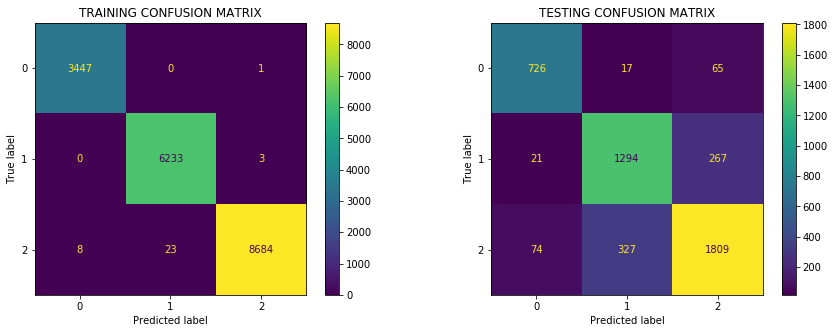

In [132]:
run_model(dtree, vect_X_train, y_train, vect_X_test, y_test, 3)

Good scores, but problem with overfitting. 10 point difference in recall 'earn' parameter

# Decision Tree - Merged DF

In [135]:
X = df_merged.drop(['topic'], axis=1)
y = df_merged['topic']

X_train, X_test, y_train, y_test = train_test_split(X['text'], y, test_size=0.20, random_state=200)

In [136]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
vect_X_train = vectorizer.fit_transform(X_train)
vect_X_test = vectorizer.transform(X_test)

dtree = DecisionTreeClassifier(max_depth=None)
dtree.fit(vect_X_train, y_train)

DecisionTreeClassifier()

TRAINING - Classification Report
Accuracy: 100.0%
Precision: 99.9%
Recall: 100.0%
F1: 99.9%
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3448
           2       1.00      1.00      1.00     14951

    accuracy                           1.00     18399
   macro avg       1.00      1.00      1.00     18399
weighted avg       1.00      1.00      1.00     18399

TESTING - Classification Report
Accuracy: 96.0%
Precision: 93.2%
Recall: 92.8%
F1: 93.0%
              precision    recall  f1-score   support

           1       0.89      0.88      0.88       808
           2       0.97      0.98      0.98      3792

    accuracy                           0.96      4600
   macro avg       0.93      0.93      0.93      4600
weighted avg       0.96      0.96      0.96      4600



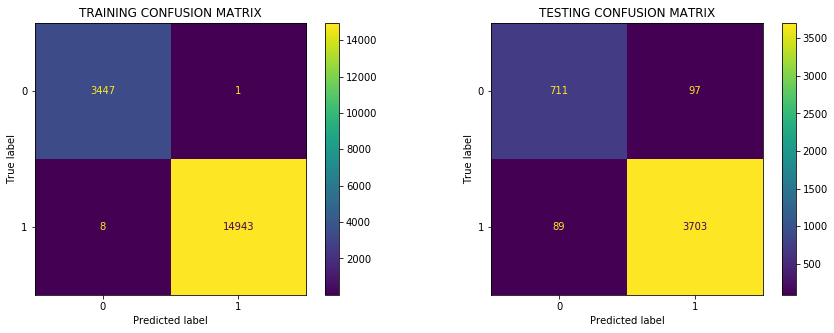

In [137]:
run_model(dtree, vect_X_train, y_train, vect_X_test, y_test, 2)

Similar results, but the overfitting problem is a tad worse with the merged df.